# Tracking cantilever deflection using auto-correlation algorithm

The code below demonstrates how to track cantilever deflection in python, using auto-correlation algorithm in scikit-image (http://scikit-image.org/) library. Instructions on setting up python on your computer can be found in https://swcarpentry.github.io/2013-08-23-harvard/. 

Other libraries required: 
1. numpy
2. matplotlib
3. scipy
4. pandas
5. seaborn
6. imageio

To read video file correctly, ffmpeg must be installed (https://www.ffmpeg.org/). 

## Read video file and template image

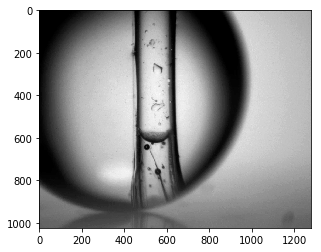

In [1]:
%matplotlib inline

import imageio
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from skimage.feature import match_template

filename = '100um_s_5fps.mov'
vid = imageio.get_reader(filename,  'ffmpeg')

# First frame from the video
img = vid.get_data(0)
img = img[:,:,0]       #Read only the first channel (red) from the RGB image
plt.imshow(img, cmap=plt.cm.gray)

Template size is 45 px by 45 px


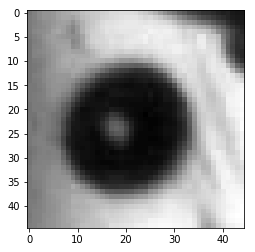

In [2]:
# reading template
template = plt.imread('template_100um_s_5fps_0.png')
template = template[:,:,0]
h, w = np.shape(template)

plt.imshow(template, cmap=plt.cm.gray)

print "Template size is %d px by %d px" %(h, w)


# Searching for match

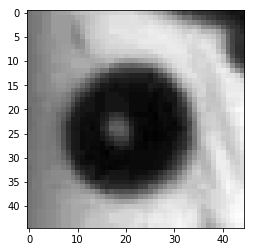

In [3]:
result = match_template(img, template)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

img_found = img[y:y+h,x:x+w] 
template = img_found           #update template
plt.imshow(template, cmap=plt.cm.gray)

# Tracking using auto-correlation algorithm

In [4]:
import time
start_time = time.time() # monitor time taken

pos_x_arr = []   # x-position 
pos_y_arr = []   # y-position
err_arr = []     # error 

err_max = 0.3
x_shift = 0
y_shift = 0

for i, img in enumerate(vid):    
    img = img[:,:,0]
    img_matched = img[y:y+h,x:x+w] 
    
    #auto-correlation algorithm
    shift, error, diffphase = register_translation(template, img_matched, 100)
    
    dx = shift[1] - x_shift 
    dy = shift[0] - y_shift 
    
    if error < err_max:   # accept results if the error is small
        pos_x_arr.append(dx)
        pos_y_arr.append(dy)
        err_arr.append(error)
    
    else:                 # Otherwise search for template-match again 
        result = match_template(img, template)
        ij = np.unravel_index(np.argmax(result), result.shape)
        x_o, y_o = ij[::-1]
        x_shift = (x_o - x) + x_shift
        y_shift = (y_o - y) + y_shift
        x = x_o
        y = y_o

print("--- %s seconds elapsed---" % (time.time() - start_time))


--- 2.14814090729 seconds elapsed---


Using the python code above, it takes about 2 s to track the cantilever deflection for 202 frames. 

The same auto-correlation algorithm can also be performed using a free open-source software, OSP tracker (https://physlets.org/tracker/), but it takes longer (43.2 s) to track the same template feature.

# Plot data

We will now compare the tracking results from using python and OSP tracker.

In [5]:
# Setting up plotting parameters
import pandas as pd
import seaborn as sns

def plot_data(fig, ax):
    ls_1 = 1.0
    ls_2 = 1.0
    ls_3 = 0.8

    ms = 8 # marker size
    fs_1 = 12
    fs_2 = 12
    
    ax.tick_params(axis='x', labelsize=fs_1)
    ax.tick_params(axis='y', labelsize=fs_1)

    scale = 3
    fig.set_size_inches(scale*2.1,scale*1.67)

    ax.xaxis.set_tick_params(length=4)
    ax.yaxis.set_tick_params(length=4)

    
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(1.1)

def plot_data_2(fig, ax):
    ls_1 = 1.0
    ls_2 = 1.0
    ls_3 = 0.8

    ms = 8 # marker size
    fs_1 = 14
    fs_2 = 14
    
    ax.tick_params(axis='x', labelsize=fs_1)
    ax.tick_params(axis='y', labelsize=fs_1)

    scale = 1.5
    fig.set_size_inches(scale*2.1,scale*1.67)

    ax.xaxis.set_tick_params(length=4)
    ax.yaxis.set_tick_params(length=4)

    
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(1.1)
    
color_b = sns.xkcd_rgb["marine"]
color_g = sns.xkcd_rgb["forest green"]
color_r = sns.xkcd_rgb["pale red"]
color_i = sns.xkcd_rgb["indigo"]


In [6]:
# importing data from tracker
df = pd.read_csv("tracking.csv")
dt = 0.2  # time between frames

pos_x_arr_tracker = df["x_px"].values
t_arr = np.arange(len(pos_x_arr_tracker))*dt

df.head()

,﻿n_frame,x_px
0,0,0.106769
1,1,0.038345
2,2,0.049689
3,3,0.079627
4,4,0.072428


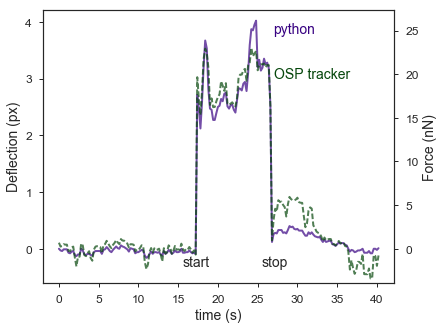

In [7]:
sns.set_style("white")
fig_1,ax_1 = plt.subplots()

# results from python code
ax_1.plot(t_arr, pos_x_arr, color=color_i, 
          alpha=0.7, linewidth=2)

# results from tracker
ax_1.plot(t_arr, pos_x_arr_tracker, '--', color=color_g, 
          alpha=0.7, linewidth=2)

plot_data(fig_1, ax_1)
ax_1.set_xlabel("time (s)", fontsize = 14)
ax_1.set_ylabel("Deflection (px)", fontsize = 14)

ax_1.text(15.5, -0.3, "start", fontsize=14)
ax_1.text(25.5, -0.3, "stop", fontsize=14)

ax_1.text(27, 3.8, "python", fontsize=14, color=color_i)
ax_1.text(27, 3.0, "OSP tracker", fontsize=14, color=color_g)

ax_1.set_ylim(-0.6,4.2)

# secondary Y-axis
k = 6.5 #nN/px 
F = np.array(pos_x_arr)*k

ax_2 = ax_1.twinx()
ax_2.set_ylabel("Force (nN)", fontsize = 14)
ax_2.set_ylim(-0.6*k,4.2*k)
plot_data(fig_1, ax_2)



In [8]:
fig_1.savefig("deflection.pdf", transparent=True)

(-2.6, 2.6)

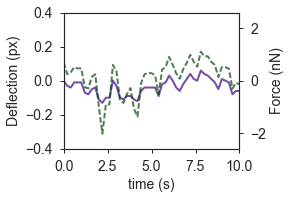

In [9]:
fig_2,ax_1 = plt.subplots()

# results from python code
ax_1.plot(t_arr, pos_x_arr, color=color_i, 
          alpha=0.7, linewidth=2)

# results from tracker
ax_1.plot(t_arr, pos_x_arr_tracker, '--', color=color_g, 
          alpha=0.7, linewidth=2)

plot_data_2(fig_2, ax_1)
ax_1.set_xlabel("time (s)", fontsize = 14)
ax_1.set_ylabel("Deflection (px)", fontsize = 14)

# secondary Y-axis
k = 6.5 #nN/px 
F = np.array(pos_x_arr)*k

ax_2 = ax_1.twinx()
ax_2.set_ylabel("Force (nN)", fontsize = 14)
ax_2.set_ylim(-0.6*k,4.2*k)
plot_data_2(fig_2, ax_2)

ax_1.set_xlim([0,10])
ax_1.set_ylim([-0.4,0.4])
ax_2.set_ylim([-0.4*k,0.4*k])


In [10]:
fig_2.savefig("deflection_zoomed.pdf", transparent=True)